In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [2]:
import zipfile

zip_file = 'archive (1).zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('unzipped_content')


In [3]:
import os

for root, dirs, files in os.walk('unzipped_content'):
    for file in files:
        print(os.path.join(root, file))


unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_007.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_358.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_389.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_008.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_379.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_045.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_093.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_353.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_273.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_239.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_325.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_274.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_363.jpg
unzipped_content/TrashType_Image_Dataset/cardboard/cardboard_003.jpg
unzipped_content/TrashType_Image_D

In [4]:
!ls

'archive (1).zip'   sample_data   unzipped_content


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr

In [6]:
# config.py (or in the same notebook top section)
dataset_dir = "/content/unzipped_content/TrashType_Image_Dataset"  # Adjust if inside Colab
image_size = (124, 124)
batch_size = 32
seed = 42


In [7]:
def load_datasets(dataset_dir, image_size=(124, 124), batch_size=32, seed=42):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size
    )

    class_names = train_ds.class_names

    # Split validation into val/test
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_ds = val_ds.take(val_batches // 2)
    val_ds = val_ds.skip(val_batches // 2)

    return train_ds, val_ds, test_ds, class_names


In [8]:
def normalize_datasets(train_ds, val_ds, test_ds):
    normalization_layer = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds, test_ds


In [9]:
def optimize_datasets(train_ds, val_ds, test_ds):
    train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds


In [10]:
def visualize_samples(dataset, class_names):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(12, len(images))):
            ax = plt.subplot(4, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()


In [11]:
def visualize_samples(dataset, class_names):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(12, len(images))):
            ax = plt.subplot(4, 3, i + 1)
            img = images[i].numpy()  # No astype("uint8") if already uint8
            # If image is float and range 0–1, convert it back for display:
            if img.dtype == np.float32:
                img = (img * 255).astype(np.uint8)
            plt.imshow(img)
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()


In [19]:
def visualize_samples(dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(min(12, len(images))):  # Show up to 12 images
            ax = plt.subplot(4, 3, i + 1)
            img = images[i].numpy()

            # If image is normalized (float32, 0–1), convert to 0–255 for display
            if img.dtype == np.float32 and img.max() <= 1.0:
                img = (img * 255).astype("uint8")

            plt.imshow(img)
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.tight_layout()
    plt.show()


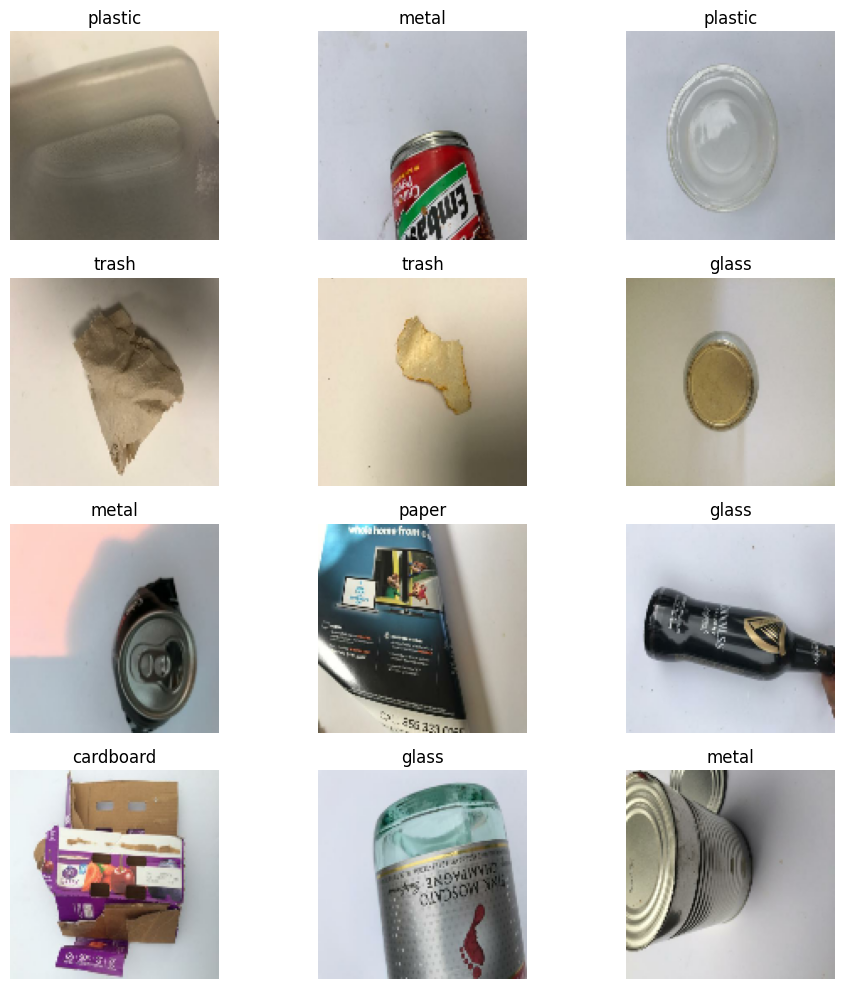

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(12, len(images))):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def get_class_weights(dataset, class_names):
    labels = []

    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy())

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(len(class_names)),
        y=labels
    )

    return dict(enumerate(class_weights))


In [23]:
class_weights = get_class_weights(train_ds, class_names)
print(class_weights)

{0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [24]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts


In [25]:
def simple_bar_plot(dist, title):
    import matplotlib.pyplot as plt

    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [26]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [27]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [28]:
import os
os.listdir("/content")


['.config', 'archive (1).zip', 'unzipped_content', 'sample_data']

In [29]:
os.listdir("/content/unzipped_content")


['TrashType_Image_Dataset']

In [30]:
dataset_dir = "/content/unzipped_content"


In [31]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(124, 124),
    batch_size=32
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(124, 124),
    batch_size=32
)

# ✅ Now this should work
class_names = train_ds_raw.class_names
print("Class names:", class_names)


Found 2527 files belonging to 1 classes.
Using 2022 files for training.
Found 2527 files belonging to 1 classes.
Using 505 files for validation.
Class names: ['TrashType_Image_Dataset']


In [32]:
dataset_dir = "/content/unzipped_content"  # adjust if needed

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(124, 124),
    batch_size=32
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(124, 124),
    batch_size=32
)

class_names = train_ds_raw.class_names  # <-- save this here once!
print("Class names:", class_names)


Found 2527 files belonging to 1 classes.
Using 2022 files for training.
Found 2527 files belonging to 1 classes.
Using 505 files for validation.
Class names: ['TrashType_Image_Dataset']


In [33]:
train_ds = train_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [34]:
# Assuming you have count_distribution() function defined somewhere

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)

# If you have a test dataset, do the same for test_dist, else skip
# test_dist = count_distribution(test_ds, class_names)  # if test_ds exists

overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print("Train distribution:", train_dist)
print("Validation distribution:", val_dist)
# print("Test distribution:", test_dist)  # if applicable
print("Overall distribution:", overall_dist)


Train distribution: {'TrashType_Image_Dataset': 100.0}
Validation distribution: {'TrashType_Image_Dataset': 100.0}
Overall distribution: {'TrashType_Image_Dataset': 100.0}


In [35]:
def count_distribution(dataset, class_names):
    total_images = 0
    counts = {class_name: 0 for class_name in class_names}
    num_classes = len(class_names)

    for _, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            if 0 <= label < num_classes:  # safe check
                class_name = class_names[label]
                counts[class_name] += 1
                total_images += 1
            else:
                print(f"Warning: label {label} is out of range!")

    percentages = {k: round((v / total_images) * 100, 2) if total_images > 0 else 0 for k, v in counts.items()}
    return percentages


In [36]:
class_names = train_ds_raw.class_names  # from your dataset loading step


In [37]:
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)

# Optionally, calculate overall as average of train + val
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)


{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}


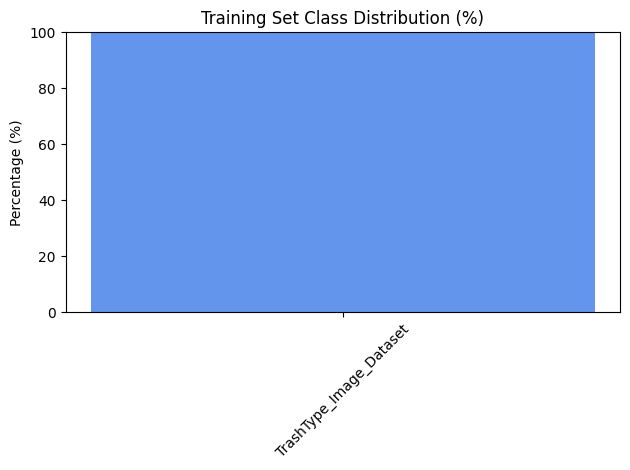

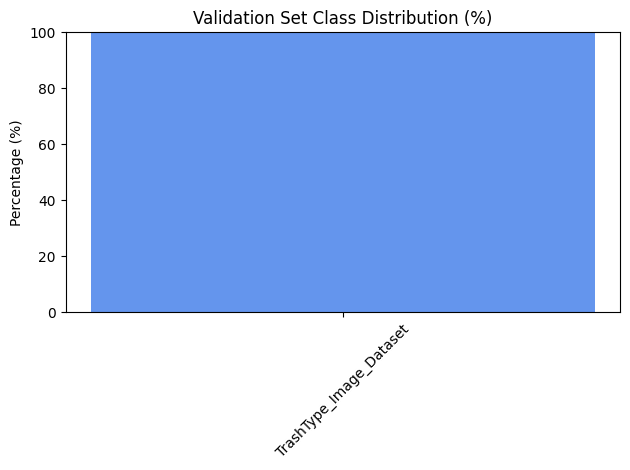

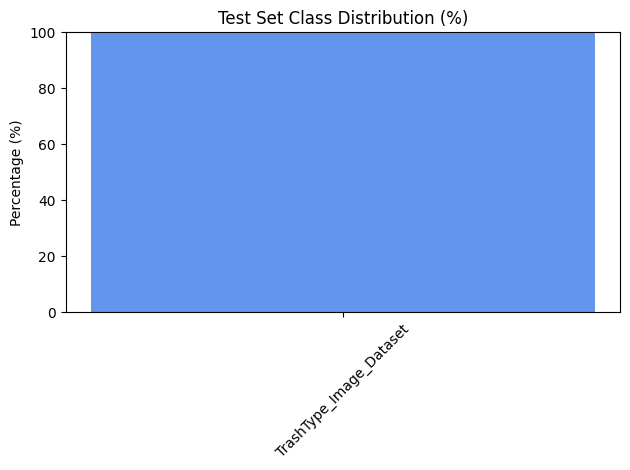

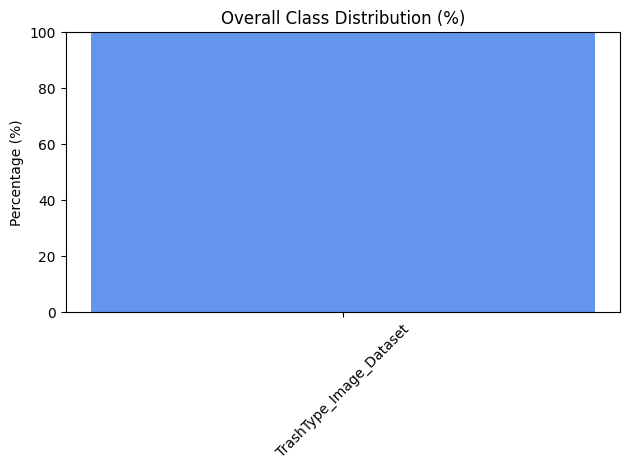

In [38]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [39]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2527 files belonging to 1 classes.
Using 2022 files for training.
Found 2527 files belonging to 1 classes.
Using 505 files for validation.


In [40]:
class_names = train_ds.class_names  # This will be the correct list of class names


In [41]:
print("Class names:", class_names)

for _, labels in test_ds.take(1):
    print("Sample labels from test_ds batch:", labels.numpy())


Class names: ['TrashType_Image_Dataset']
Sample labels from test_ds batch: [1 0 2 4 1 5 3 0 1 3 4 3 1 1 0 1 3 3 1 2 4 2 1 3 2 0 5 2 4 3 0 3]


In [42]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [43]:
train_dist = {'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}


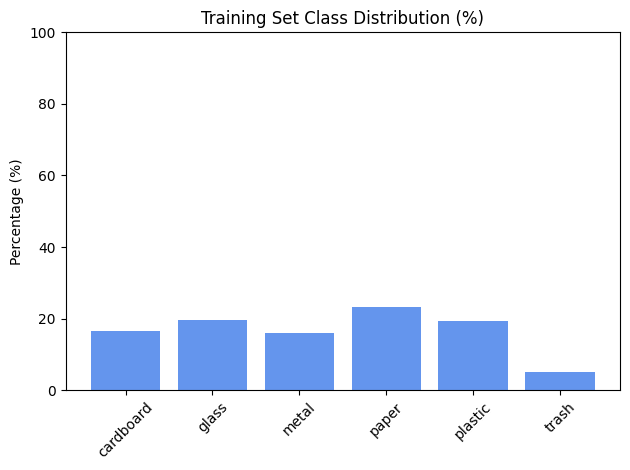

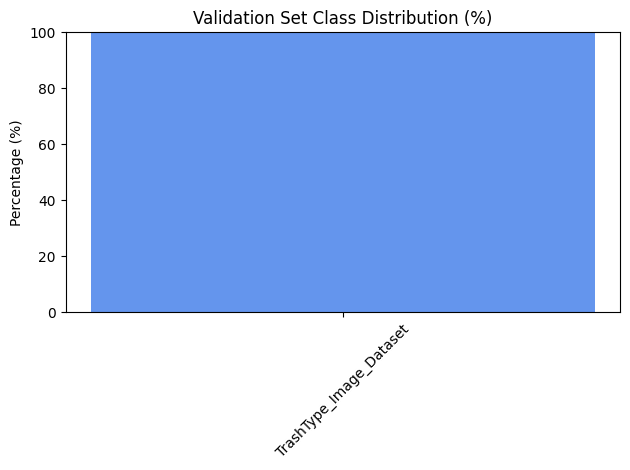

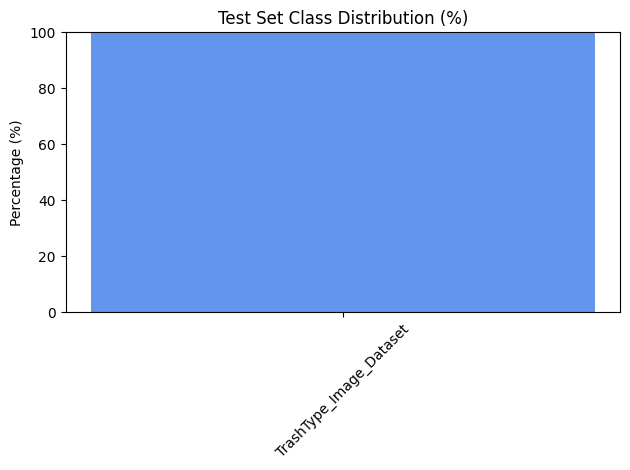

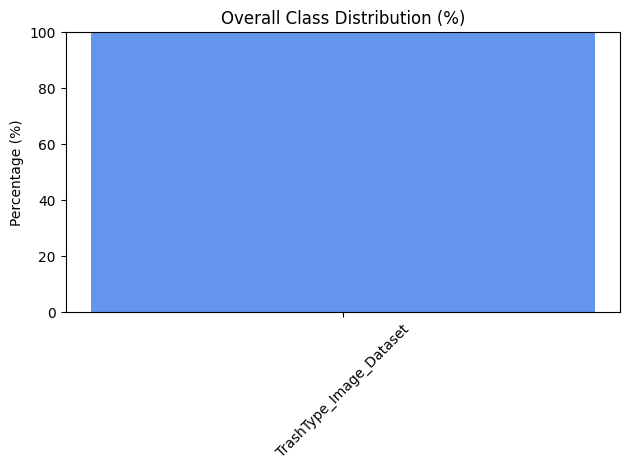

In [44]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


In [45]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [46]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 2022}
Class Weights: {0: np.float64(1.0)}


In [47]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [48]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [50]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [52]:
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.4448 - loss: 1.5025 - val_accuracy: 0.9822 - val_loss: 0.4583
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9841 - loss: 0.3063 - val_accuracy: 0.9980 - val_loss: 0.0887
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 1.0000 - loss: 0.0507 - val_accuracy: 1.0000 - val_loss: 0.0258
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9988 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - v

In [53]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [54]:
base_model.summary() # Print the architecture summary of the base model


Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

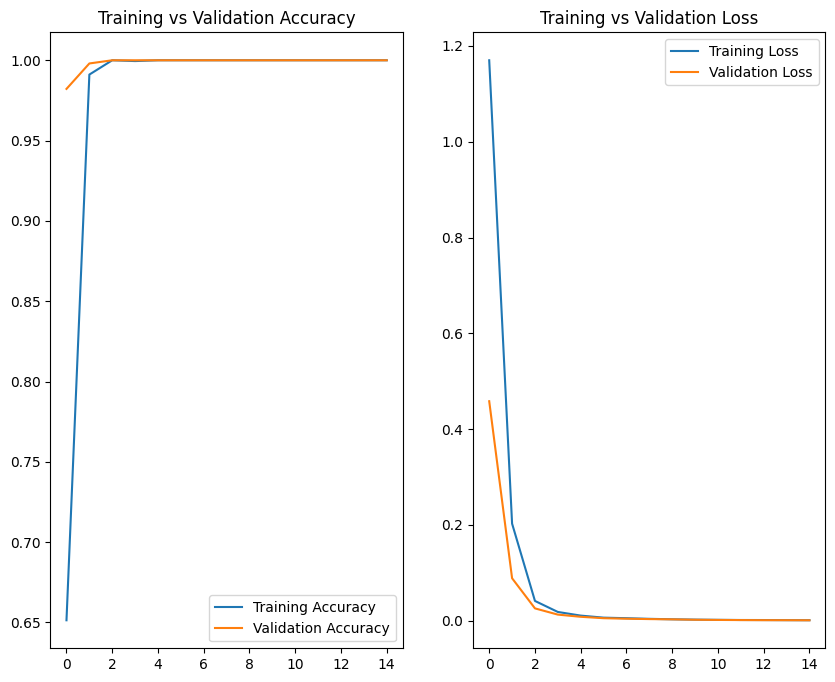

In [55]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()

In [56]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 798ms/step - accuracy: 0.1287 - loss: 7.8026
Test accuracy is0.1445, Test loss is 7.6535


In [57]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 897ms/step
[[37  0  0  0  0  0]
 [47  0  0  0  0  0]
 [48  0  0  0  0  0]
 [57  0  0  0  0  0]
 [46  0  0  0  0  0]
 [21  0  0  0  0  0]]
              precision    recall  f1-score   support

           0       0.14      1.00      0.25        37
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00        46
           5       0.00      0.00      0.00        21

    accuracy                           0.14       256
   macro avg       0.02      0.17      0.04       256
weighted avg       0.02      0.14      0.04       256



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


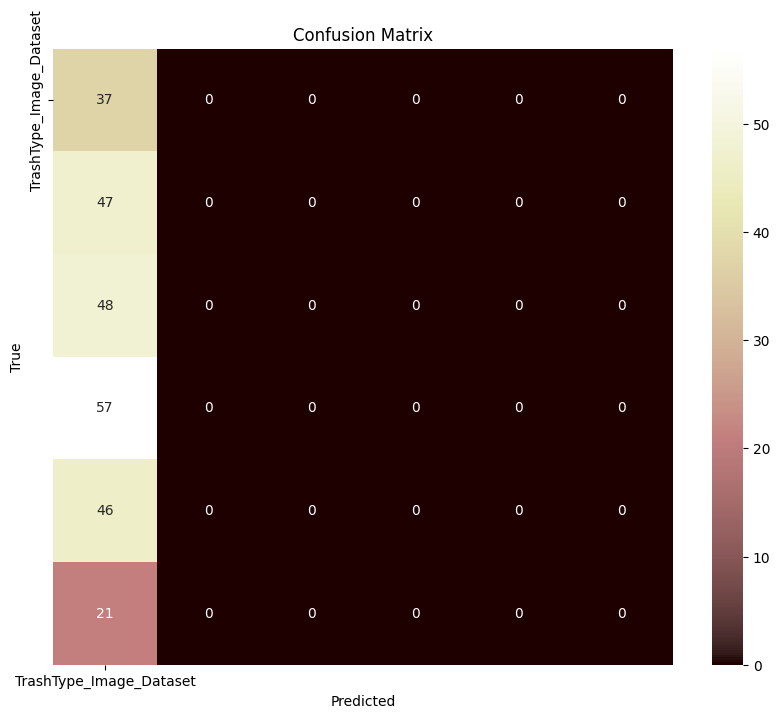

In [59]:

plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='pink')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
⚠️ Skipping image 0 due to out-of-range index: true=1, pred=0
⚠️ Skipping image 1 due to out-of-range index: true=1, pred=0


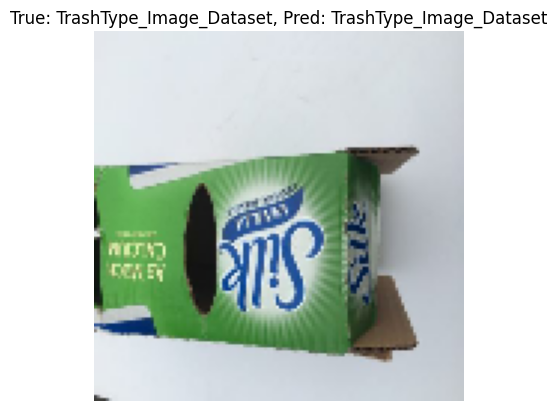

⚠️ Skipping image 3 due to out-of-range index: true=5, pred=0
⚠️ Skipping image 4 due to out-of-range index: true=2, pred=0
⚠️ Skipping image 5 due to out-of-range index: true=1, pred=0


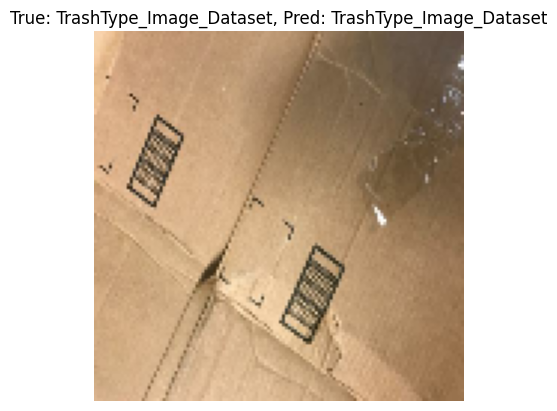

⚠️ Skipping image 7 due to out-of-range index: true=5, pred=0


In [63]:
class_names = train_ds.class_names

for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(min(8, len(images))):
        # Safely convert label tensors to integer
        true_index = int(labels[i].numpy())
        pred_index = int(pred_labels[i].numpy())

        # Just to be sure they are within class_names range
        if true_index < len(class_names) and pred_index < len(class_names):
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true_index]}, Pred: {class_names[pred_index]}")
            plt.axis("off")
            plt.show()
        else:
            print(f"⚠️ Skipping image {i} due to out-of-range index: true={true_index}, pred={pred_index}")


In [64]:
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [65]:
!pip install gradio


In [66]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input


In [67]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [68]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://154277a5697469640b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
